# Density Estimation with Neural ODEs

`torchdyn` allows for easy implementation of density estimation models. Continuous normalizing flows (CNFs) sidestep architectural restrictions of discrete flows, necessary to preserve tractability of Jacobian log-determinants. By means of a change of variables in continuous-depth, the determinant requirement turns into a much cheaper trace requirement. 

The flow is normalized by this instantaneous divergence to preserve the integral norm of the density throughout the dynamics. We refer to this excellent tutorial and survey for an in-depth introduction.

This notebooks shows a regular *continuous normalizing flow* [CNF](https://arxiv.org/abs/1806.07366), implemented with a few lines of `torchdyn`.

In [1]:
import sys ; sys.path.append('../')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *

**Data**: we use a standard N-gaussians dataset. The data is z-normalized for easier training.

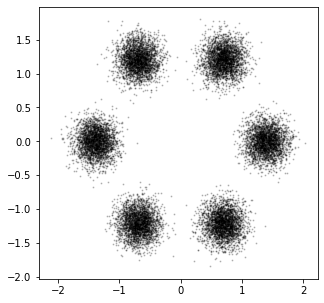

In [2]:
data = ToyDataset()
n_samples = 1 << 14
n_gaussians = 6 
X, yn = data.generate(n_samples // n_gaussians, 'gaussians', n_gaussians=6, std_gaussians=0.5, radius=4, dim=2)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c='black', alpha=0.2, s=1.)

In [3]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn).long().to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True) 

## Continuous Normalizing Flow

First, we show a minimal implementation of a standard *continuous normalizing flow* (`CNF`). This exercise showcases the flexibility of `torchdyn`: a `CNF` can be defined as nothing more than a wrap for any module, handling the additional dimension dedicated to the divergence propagation during forward and backward dynamics. This approach is natural as it allows the utilization of any other `func` variant to handle the data-dynamics.

In [4]:
def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]  
    return trJ

class CNF(nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace;
        self.noise_dist, self.noise = noise_dist, None
        if self.trace_estimator in REQUIRES_NOISE:
            assert self.noise_dist is not None, 'This type of trace estimator requires specification of a noise distribution'
            
    def forward(self, x):   
        with torch.set_grad_enabled(True):
            x_in = torch.autograd.Variable(x[:,1:], requires_grad=True).to(x) # first dimension reserved to divergence propagation          
            # the neural network will handle the data-dynamics here
            x_out = self.net(x_in)
                
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return torch.cat([-trJ[:, None], x_out], 1) + 0*x # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

The above template also lends itself to a simple `FFJORD` implementation by a simple change of `jacobian_trace`

A "correct" solution of the dynamics ODE is often required for CNFs for accuracy in the divergence dynamics. This suggests the use of adaptive-step solvers such as `dopri5`, `dopri8` or `adaptive heun`. However, fixed-step solvers with a fine-enough grid `s_span` can be successfully employed as well, depending on complexity of the learned flows:

In [5]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )

# cnf wraps the net as with other energy models
# default trace_estimator, when not specified, is autograd_trace
cnf = CNF(f, trace_estimator=autograd_trace)
nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), sensitivity='adjoint', atol=1e-4, rtol=1e-4)

Augmenter takes care of setting up the additional scalar dimension for the divergence dynamics.
The `DEFunc` wrapper (implicitly defined when passing `f` to the NeuralDE) will ensure compatibility of depth-concatenation and data-control with the divergence dimension.

Utilizing additional augmented dimensions is also compatible, as only the first will be used for the jacobian trace. Note that `Augmenter` concatenates augmented dimensions before (in the "order" sense) the input. CNFs utilize the first dimension (i.e `x[:, 0]`) to keep track of the divergence.

In [6]:
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

CNFs require the specification of a prior distribution in latent space. We use a simple isotropic `Multivariate Normal`:

In [7]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

Standard Learner. It is often useful to visualize samples during normalizing flow training, in order to identify issues quickly and stop runs that are not promising. For an example of how to log images using `PyTorch Lightning` and `Wandb`, refer to torchdyn's `benchmark` notebooks.

In [8]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1
        x, _ = batch 
        xtrJ = self.model(x)  
        logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
        loss = -torch.mean(logprob)
        nde.nfe = 0
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

A warning: the training process can take 1 hour or more depending on hardware. Following tutorials will show how to speed up CNF training through stochastic trace estimators and / or integral regularization terms.

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=300)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 8 K   


## Visualizing the Samples

Sampling from CNFs is easy: we query the prior latent normal and then pass the samples through the `z -> x` CNF flow. To reverse the flow, we flip `s_span`:

In [ ]:
sample = prior.sample(torch.Size([1 << 14]))
# integrating from 1 to 0
model[1].s_span = torch.linspace(1, 0, 2)
new_x = model(sample).cpu().detach()

We then plot, samples, flows and density like so:

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.3, c='blue', edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Samples')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=2.3, alpha=0.2, c='red',  linewidths=0.3, edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Data')

We can also visualize the flows from prior to the input data space using the `.trajectory` method

In [ ]:
traj = model[1].trajectory(Augmenter(1, 1)(sample.cuda()), s_span=torch.linspace(1, 0, 100)).detach().cpu() ; 
sample = sample.cpu()
traj = traj[:, :, 1:] # scrapping first dimension := jacobian trace

In [ ]:
n = 2000
plt.figure(figsize=(6,6))
plt.scatter(sample[:n,0], sample[:n,1], s=10, alpha=0.8, c='black')
plt.scatter(traj[:,:n,0], traj[:,:n,1], s=0.2, alpha=0.2, c='olive')
plt.scatter(traj[-1,:n,0], traj[-1,:n,1], s=4, alpha=1, c='blue')
plt.legend(['Prior sample z(S)', 'Flow', 'z(0)'])

Great! You've seen how to train vanilla continuous normalizing flows in `torchdyn`. Next, we'll look at the *Free-form Jacobian of Reversible Dynamics* (FFJORD) variant proposed in [Grathwohl et al., 2018](https://arxiv.org/pdf/1810.01367.pdf).